<h1>Hole and Boundary Detection</h1>

In this particular notebook, we use the ground plane filtered dataset and detect the holes and boundaries for the vehicles. We do it in the following ways
1) Data Cleaning - Noise Elimination
2) Hole Detection - Delaunay Triangulation
3) Hole Detection  - Sensitivity Analysis
4) Boundary Detection - Convex Hulls

In [1]:
# Loading all the necessary libraries
import pdal
import numpy as np
import pandas as pd
import laspy
import open3d as o3d
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import statistics

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Reading the previous CSF ground plane filtered file (".laz" format)
file_path = 'CSF_Filtering_Output.laz'  
lidar_data = laspy.read(file_path)

# Preparing the data extracting the coordinates
coords = np.vstack((lidar_data.x, lidar_data.y, lidar_data.z)).transpose()

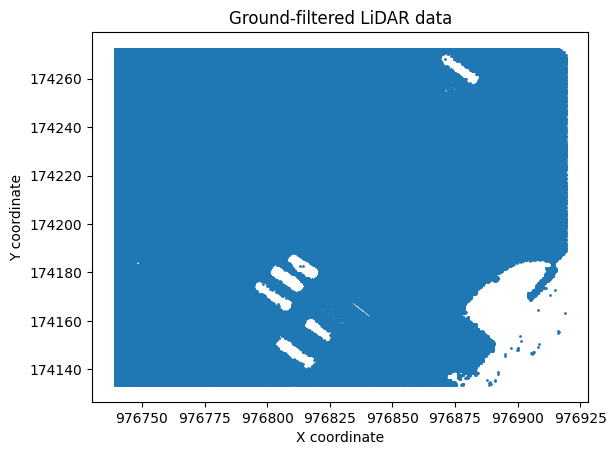

In [3]:
# Plotting the filtered coordinates 
plt.scatter(coords[:, 0], coords[:, 1], s=1)  
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Ground-filtered LiDAR data')
plt.show()

<h3>1. Data Cleaning - Noise Elimination </h3> 

In this particular stage, we compute the mean and standard deviation of z coordinates of the filtered dataset. Further we eliminate points beyond 2 standard deviations indicating that they could most possibly be outliers. We then plot the data to observe the difference.

z_mean=8.504140004296662
z_std=0.6036658541744861


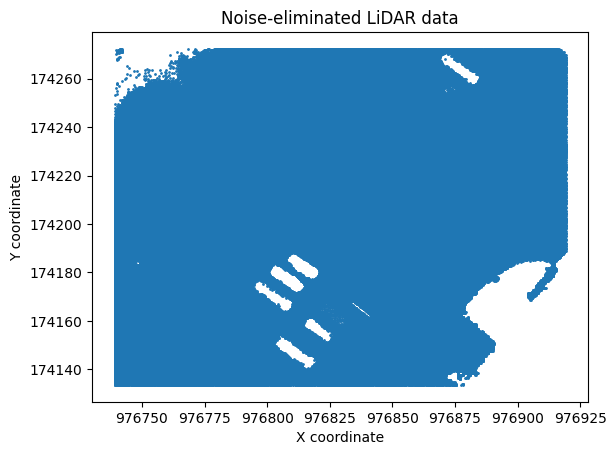

In [4]:
# Computing the mean and standard deviation of z coordinates
z_mean = np.mean(coords[:, 2])
z_std = np.std(coords[:, 2])
print(f"z_mean={z_mean}")
print(f"z_std={z_std}")

# Defining a threshold for Z values and considering within 2 standard deviations from the mean
threshold = 2

# Create a mask to filter out the points based on the threshold
mask = np.abs(coords[:, 2] - z_mean) < threshold * z_std
data_filtered = coords[mask]

# Plotting the noise-eliminated data
plt.scatter(data_filtered[:, 0], data_filtered[:, 1], s=1)
plt.title("Noise-eliminated LiDAR data")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.show()


In [5]:
# Considering only x and y coordinates for further processing and analysis of holes
points_2d = data_filtered[:, :2]

<h3> 2. Hole Detection - Delaunay Triangulation </h3>

To detect the holes, we leverage the concept of Delaunay triangulation and use the implementation from the ``` scipy.spatial ``` library. 

**Delaunay Triangulation** 
> It connects all the nodes in the form of mesh which we can leverage and use triangle properties to identify holes in the ground plane

In the below cells, we use 3 functions to detect holes.
1) ``` calculate_area() ``` : We calculate the area of the triangle formed by the connected nodes. We retrieve the nodes (vertices) using the simplices produced by the ``` delaunay ``` object.
2) ``` calculate_aspect_ratio() ``` : We calculate the aspect ratio of the longest side and the shortest side using the vertices of the triangle.
3) ``` detect_holes() ``` : We detect the holes by iteratively going through every simplice (triangle vertices) and check whether they meet certain threshold criteria in terms of area and aspect ratio

In [6]:
# Hole Detection

# Calculate the area of a triangle from its vertices
def calculate_area(v1, v2, v3):
    # Using Heron's formula
    a = np.linalg.norm(v2 - v1)
    b = np.linalg.norm(v3 - v2)
    c = np.linalg.norm(v1 - v3)
    s = (a + b + c) / 2
    area = s * (s - a) * (s - b) * (s - c)
    
    # Check if the area calculation is negative due to floating point inaccuracy
    if area < 0 and np.isclose(area, 0):
        area = 0
    return np.sqrt(area) if area >= 0 else 0

# Calculate the aspect ratio of a triangle from its vertices
def calculate_aspect_ratio(v1, v2, v3):
    edges = [np.linalg.norm(v2 - v1), np.linalg.norm(v3 - v2), np.linalg.norm(v1 - v3)]
    max_edge = max(edges)
    min_edge = min(edges)
    return max_edge / min_edge if min_edge > 0 else np.inf
    
# Detect holes by passing all the filtered points and respective thresholds.
def detect_holes(points_2d, threshold_area, max_area, aspect_ratio_threshold):
    tri = Delaunay(points_2d)
    hole_candidates = []
    aspect_ratios = []

    for t in tri.simplices:
        v1, v2, v3 = points_2d[t[0]], points_2d[t[1]], points_2d[t[2]]
        area = calculate_area(v1, v2, v3)
        aspect_ratio = calculate_aspect_ratio(v1, v2, v3)

        aspect_ratios.append(aspect_ratio)
        if threshold_area < area < max_area and aspect_ratio < aspect_ratio_threshold:
            hole_candidates.extend(t)

    #print(f"Max aspect ratios of all triangles: {max(aspect_ratios)}")
    #print(f"Mean aspect ratios of all triangles: {statistics.mean(aspect_ratios)}")
    return np.unique(hole_candidates), tri

In [7]:
# Trial and random initialization of thresholds to validate the execution of functions above
max_area=6
threshold_area = 1
aspect_ratio_threshold = 6 
points_around_holes, triangulation = detect_holes(points_2d, threshold_area, max_area, aspect_ratio_threshold)


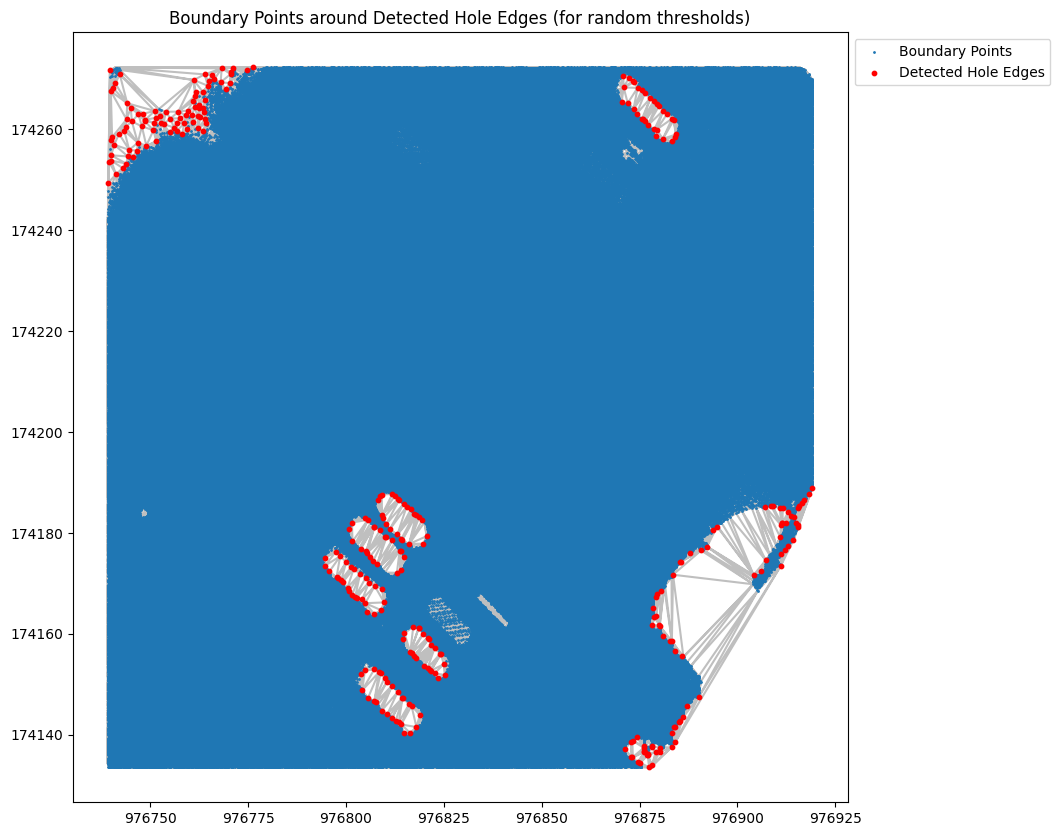

In [8]:
# Plotting the holes detected from the above random thresholds.
plt.figure(figsize=(10, 10))
plt.triplot(points_2d[:, 0], points_2d[:, 1], triangulation.simplices.copy(), color='gray', alpha=0.5)
plt.scatter(points_2d[:, 0], points_2d[:, 1], label='Boundary Points', s=1)
plt.scatter(points_2d[points_around_holes, 0], points_2d[points_around_holes, 1], color='r', label='Detected Hole Edges', s=10)
plt.title('Boundary Points around Detected Hole Edges (for random thresholds)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()


<h3> 3. Hole Detection  - Sensitivity Analysis </h3>

To choose thresholds with more intent, we decided to perform **Sensitivity Analysis** to understand the distribution of the points and appropriately choose a threshold to detect the holes. To detect the holes, we calculate the average spacing between the nodes using ``` KDTree ``` library. We then initialize thresholds to multiples of average spacing ``` [2, 2.5, 3, 4, 5] ``` and run the above function to check the distribution of the points and accordingly choose the points. We use the optimal value for the threshold.

In the below cell,
1. ``` calculate_average_spacing() ``` : We compute the average spacing between all the nodes by using the *nearest_neighbor* concept from KDTrees. 

In [15]:
'''
# Compute the average spacing between nodes
def calculate_average_spacing(points_2d):
    tree = KDTree(points_2d)
    distances, _ = tree.query(points_2d, k=2) 
    average_spacing = np.mean(distances[:, 1])  
    return average_spacing

average_spacing = calculate_average_spacing(points_2d)
print(f"average_spacing: {average_spacing}")

# The number of threshold candidates are defined below
multiples = [2, 2.5, 3, 4, 5]
results = []


for multiple in multiples:
    threshold_area = multiple * average_spacing
    max_area = 50 * average_spacing 
    aspect_ratio_threshold = 100 
    
    # We decide the threshold area by iteratively calling the detect_holes() function 
    # and validating the number of boundary points detected along with the holes
    points_around_holes, triangulation = detect_holes(points_2d, threshold_area, max_area, aspect_ratio_threshold)
    
    # Plotting a figure for each threshold candidate
    plt.figure(figsize=(12, 10))
    plt.triplot(points_2d[:, 0], points_2d[:, 1], triangulation.simplices.copy(), color='gray', alpha=0.5)
    plt.scatter(points_2d[:, 0], points_2d[:, 1], label='Ground Points', s=1)
    plt.scatter(points_2d[points_around_holes, 0], points_2d[points_around_holes, 1], color='r', label=f'Detected Hole Edges {multiple}x', s=10)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.title(f'Hole Detection Sensitivity Analysis - {multiple} times Average Spacing')
    plt.show()

    # Record the results
    results.append({'Threshold Multiple': multiple, 'Points Around Holes': len(points_around_holes)})


# We create a dataframe for further analysis
df_results = pd.DataFrame(results)
'''

'\n# Compute the average spacing between nodes\ndef calculate_average_spacing(points_2d):\n    tree = KDTree(points_2d)\n    distances, _ = tree.query(points_2d, k=2) \n    average_spacing = np.mean(distances[:, 1])  \n    return average_spacing\n\naverage_spacing = calculate_average_spacing(points_2d)\nprint(f"average_spacing: {average_spacing}")\n\n# The number of threshold candidates are defined below\nmultiples = [2, 2.5, 3, 4, 5]\nresults = []\n\n\nfor multiple in multiples:\n    threshold_area = multiple * average_spacing\n    max_area = 50 * average_spacing \n    aspect_ratio_threshold = 100 \n    \n    # We decide the threshold area by iteratively calling the detect_holes() function \n    # and validating the number of boundary points detected along with the holes\n    points_around_holes, triangulation = detect_holes(points_2d, threshold_area, max_area, aspect_ratio_threshold)\n    \n    # Plotting a figure for each threshold candidate\n    plt.figure(figsize=(12, 10))\n    pl

In [ ]:
#df_results['str'] = df_results['Threshold Multiple'].astype(str)

In [ ]:
'''
# Plotting a bar chart of the number of points detected with different threshold values
plt.figure(figsize=(10, 6))
bars = plt.bar(df_results['str'], df_results['Points Around Holes'], color='skyblue')

# Add numbers on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval), va='bottom', ha='center')  # Center the text by adjusting x position

plt.xlabel('Threshold Multiple of Average Spacing')
plt.ylabel('Number of Points Around Holes')
plt.title('Points Around Holes vs. Threshold Multiple')
plt.xticks(df_results['str'])  
plt.show()
'''

We conclude with **2x average spacing** as our threshold for detecting the holes as it detects the most number of boundary points around the holes which would help us in the further process.

In [10]:
# defining the thresholds for further computations
aspect_ratio_threshold = 100
threshold_area = 2 * average_spacing
max_area = 50 * average_spacing

In [11]:
# Calling the detect_holes() function with the final thresholds
points_around_holes, triangulation = detect_holes(points_2d, threshold_area, max_area, aspect_ratio_threshold)

D:\Anaconda\envs\PDAL\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


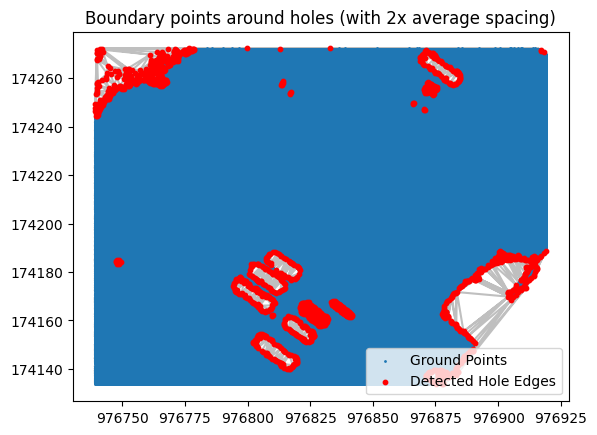

In [12]:
# Plotting with final thresholds
plt.triplot(points_2d[:, 0], points_2d[:, 1], triangulation.simplices.copy(), color='gray', alpha=0.5)
plt.scatter(points_2d[:, 0], points_2d[:, 1], label='Ground Points', s=1)
plt.scatter(points_2d[points_around_holes, 0], points_2d[points_around_holes, 1], color='r', label='Detected Hole Edges', s=10)
plt.legend()
plt.title('Boundary points around holes (with 2x average spacing)')
plt.show()

<h3>4. Boundary Detection - Convex Hulls </h3>

Next step in our analysis includes detecting the boundaries. We use the concept of Convex hulls to detect the boundaries. 

Convex Hulls
> They connect outer boundary points to create a closed shape like structure

As part of this analysis, we plan to create local hulls with a threshold radius defined to create closed shapes for all the holes. With extra boundary points, we will have extra convex hulls, which we will filter out as part of our next steps using the shape properties in convex hulls *(like the area, parallel sides and more)*

In [13]:
boundary_points = points_2d[points_around_holes]

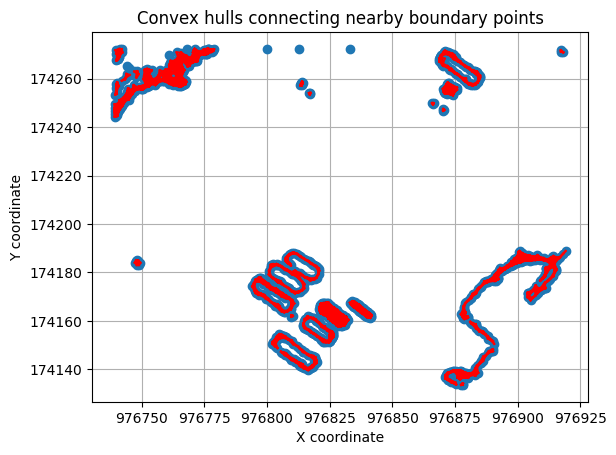

In [14]:
from scipy.spatial import ConvexHull

# Radius for neighborhood search
# TODO: To perform sensitivity analysis or another approach to decide the radius
radius = 1.75  

# Build KD-tree for efficient neighbor search
kdtree = KDTree(boundary_points)

# Find local convex hulls
local_hulls = []
for point in boundary_points:
    # Query KD-tree to find neighbors within radius
    neighbor_indices = kdtree.query_ball_point(point, radius)
    neighbor_points = boundary_points[neighbor_indices]
    
    # Don't compute convex hull if less than 2 points (as it won't be)
    if (len(neighbor_points) <= 2):
        continue
    
    # Compute convex hull of neighborhood points
    hull = ConvexHull(neighbor_points)
    local_hulls.append(hull)

# Plot the points along with local convex hulls
plt.plot(boundary_points[:,0], boundary_points[:,1], 'o', label='Points')
for hull in local_hulls:
    for simplex in hull.simplices:
        plt.plot(hull.points[simplex, 0], hull.points[simplex, 1], 'r-')

plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Convex hulls connecting nearby boundary points')
plt.grid(True)
plt.show()

We can see from the above graph the *local convex hulls* in red connecting the boundary points. This can further be improved and refined in the fiture.
All the other local convex hulls can be eliminated by using the shape properties of convex hulls defined earlier.

<h3> Next Steps </h3>

As part of next steps, we would like to filter the vehicle boundary points and then head to *the next stage in our workflow* 
> **Vehicle Detection and Data Retrieval**